# Impact of variants

We want to infer the effect of different variants onto the reproduction number. Given the positive tested COVID cases in a country we can infer the overall non variant specific effective spreading rate/reproduction number as described in \cite{dehning2020inferring}. 

Now let $y_v$ be the number of sequenced PCR tests, which correspond to variant $v$, let $n$ be the total number of sequenced tests and $\tau_{v,t}$ the relative fraction of the variant $v$ at timepoint $t$.
Assuming an independent sampling of the sequenced cases, the number of samples of a given variant $v$ is given by a Binomial distribution:

\begin{align}
 y_{v,t} \sim \text{Bin}(\tau_{v,t},n_t) \quad \forall v,t.
\end{align}


In [1]:
### Imports
import sys

sys.path.append("./covid19_inference")
import covid19_inference

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pickle
import os
import covid19_inference as cov19
from matplotlib.dates import DateFormatter,WeekdayLocator

n_threads = str(1) # per process
n_processes = 32
os.environ["MKL_NUM_THREADS"] = n_threads
os.environ["OMP_NUM_THREADS"] = n_threads
os.environ["NUMEXPR_NUM_THREADS"] = n_threads
os.environ["OPENBLAS_NUM_THREADS"] = n_threads

### Preprocess data

Here we load the variant data for chile i.e. $y_{v,t}$ and $n_{v,t}$. The resolution for the data is weekly, starting on mondays. Additionaly we download the new confirmed cases in chile with our previous developed download utils. You can find the documentation for the dataretrieval module [here](https://covid19-inference.readthedocs.io/en/latest/doc/data_retrieval.html).

In [2]:
# Load data variants
variants = pd.read_excel("./data/Chile_Variants_Updated_without_airports.xlsx",sheet_name="Variants_Count")
variants = variants.set_index('Lineage').T
variants.index.name = "Week"
variants.index = pd.to_datetime(variants.index + '-1', format='%V_%G-%u')
variants = variants.iloc[0:-1]
variant_names = ["B.1.1", "B.1.1.348", "B.1.1.7", "C.37", "P.1"]

# Load casenumbers chile and sum over weeks
jhu = covid19_inference.data_retrieval.JHU(True)
new_cases_obs = jhu.get_new(country="Chile",data_begin=variants.index[0],data_end=variants.index[-1])

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


Let us take a short look into the data. We plot the total number of sampled pcr test such as the number of test which could be per variant and the reported cases in chile.

<ipython-input-3-24b982e2ac31>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=30)


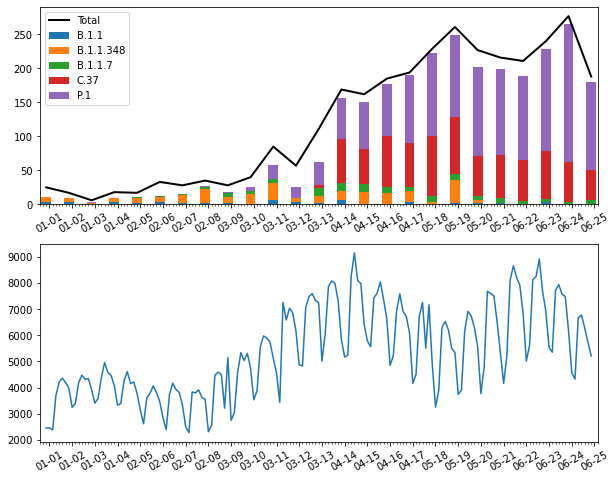

In [3]:
fig, axes = plt.subplots(2,1,figsize=(10,8))

s=0
for c in variants.columns:
    if c == "N_Total":
        continue
    axes[0].bar(variants.index,variants[c],width=3,label=c,bottom=s)
    s += variants[c]
axes[0] = covid19_inference.plot._timeseries(
    x=variants.index,
    y=variants["N_Total"],
    what="model",
    color="black",
    ax=axes[0],
    label="Total",
    lw=2
)
axes[0].legend()
axes[1] = covid19_inference.plot._timeseries(
    x=new_cases_obs.index,
    y=new_cases_obs,
    what="model",
    color="tab:blue",
    ax=axes[1],
)

# Date layout
date_form = DateFormatter("%m-%V")

# Markup
for ax in axes:
    ax.set_xticklabels(ax.get_xticks(), rotation=30)
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(WeekdayLocator(interval=1))
    _ = ax.set_xlim(variants.index[0]-timedelta(days=2), variants.index[-1]+timedelta(days=2))

fig.savefig("figures/overview.png",dpi=300)
fig.savefig("figures/overview.pdf",dpi=300)

### Create model

We defined different models and tested which one fits the dynamics best, have a look into `run_model.py` for more informations. For now we are running the default model with dirichlet likelihood and kernelized spread.

In [4]:
likelihood="dirichlet"
spreading_dynamics="kernelized_spread"
influx_factor=0.2

this_model = create_model(
    likelihood=likelihood,
    spreading_dynamics=spreading_dynamics,
    variants=variants,
    new_cases_obs=new_cases_obs,
    factor_influx=influx_factor
)

INFO     [utils] pr_sigma_date_transient was set to default value 1.5
INFO     [utils] pr_sigma_lambda was set to default value 0.2
INFO     [utils] relative_to_previous was set to default value True
INFO     [utils] pr_factor_to_previous was set to default value 1.0
INFO     [utils] pr_median_lambda was set to default value 0.125
INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [utils] pr_sigma_lambda was set to default value 0.2
INFO     [utils] relative_to_previous was set to default value True
INFO     [utils] pr_factor_to_previous was set to default value 1.0
INFO     [utils] pr_median_lambda was set to default value 0.125
INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local
INFO     [covid19_inference.model.compartmental_models] Kernelized spread with variants
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.m

In [6]:
multitrace, trace, multitrace_tuning, trace_tuning = cov19.robust_sample(
    this_model,
    draws=200,
    tune=200,
    tune_2nd=400,
    tuning_chains=12,
    final_chains=6,
    return_tuning=True,
    max_treedepth=10,
    target_accept=0.95,
)

WARNING  [pymc3] Tuning was enabled throughout the whole trace.
INFO     [pymc3] Auto-assigning NUTS sampler...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Multiprocess sampling (12 chains in 4 jobs)
INFO     [pymc3] NUTS: [factor_likelihood_log_exp, sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, median_incubation_v, new_E_begin_v, Phi_w, f_v, un_transient_len_5_raw_, un_transient_len_4_raw_, un_transient_len_3_raw_, un_transient_len_2_raw_, un_transient_len_1_raw_, un_transient_day_5, un_transient_day_4, un_transient_day_3, un_transient_day_2, un_transient_day_1, un_lambda_5_log_, un_lambda_4_log_, un_lambda_3_log_, un_lambda_2_log_, un_lambda_1_log_, un_lambda_0_log_, transient_len_13_raw_, transient_len_12_raw_, transient_len_11_raw_, transient_len_10_raw_, transient_len_9_raw_, transient_len_8_raw_, transient_len_7_raw_, transient_len_6_raw_, transient_len_5_raw_, transient_len_4_raw_, transient_len_3_raw_, transient_len_2_raw_, 

INFO     [pymc3] Sampling 12 chains for 200 tune and 0 draw iterations (2_400 + 0 draws total) took 5409 seconds.
INFO     [covid19_inference.sampling] Num chains kept: 2/12
WARNING  [covid19_inference.sampling] Not enough chains converged to minimum, we recommend increasing the number of tuning chains
WARNING  [pymc3] Only 200 samples in chain.
INFO     [pymc3] Auto-assigning NUTS sampler...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Multiprocess sampling (6 chains in 4 jobs)
INFO     [pymc3] NUTS: [factor_likelihood_log_exp, sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, median_incubation_v, new_E_begin_v, Phi_w, f_v, un_transient_len_5_raw_, un_transient_len_4_raw_, un_transient_len_3_raw_, un_transient_len_2_raw_, un_transient_len_1_raw_, un_transient_day_5, un_transient_day_4, un_transient_day_3, un_transient_day_2, un_transient_day_1, un_lambda_5_log_, un_lambda_4_log_, un_lambda_3_log_, un_lambda_2_log_, un_lambda_1_log_, un_

INFO     [pymc3] Sampling 6 chains for 400 tune and 200 draw iterations (2_400 + 1_200 draws total) took 18580 seconds.
ERROR    [pymc3] The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR    [pymc3] The estimated number of effective samples is smaller than 200 for some parameters.


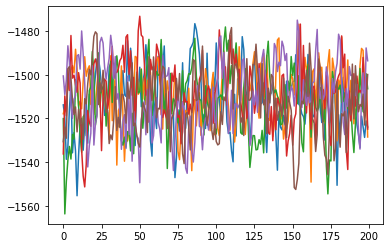

In [7]:
_ = plt.plot(trace.sample_stats["lp"].T)

In [34]:
import pickle


# Save the trace (maybe we want to load it at a later point)
with open(f"./pickled/Variants-likelihood={likelihood}-spread_method={spreading_dynamics}-influx={influx_factor}.pickle", 'wb') as f:
    pickle.dump((this_model,trace),f)

In [8]:
trace.sample_stats['lp'].mean('draw')

<xarray.DataArray 'lp' (chain: 6)>
array([-1512.2797419 , -1508.75093253, -1512.68107548, -1507.49519811,
       -1509.61111204, -1513.61062578])
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5

In [ ]:
trace.sample_stats['ess']

In [ ]:
trace.sample_stats['ess'].min()

In [9]:
trace.posterior_tmp = trace.posterior
trace.posterior = trace.posterior.isel(chain=[2,4])

In [20]:
trace.posterior = trace.posterior_tmp


## Stats and plots

First let's have a look if our chains converged to approx the same values. We can do that by computing the Rhat statistic.

In [21]:
import arviz as az
az.rhat(trace).max()

/data.nst/jdehning/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


<xarray.Dataset>
Dimensions:                  ()
Data variables: (12/136)
    lambda_0_log_            float64 1.004
    lambda_1_log_            float64 1.004
    lambda_2_log_            float64 1.021
    lambda_3_log_            float64 1.003
    lambda_4_log_            float64 1.019
    lambda_5_log_            float64 1.017
    ...                       ...
    offset_modulation        float64 1.005
    new_cases                float64 1.343
    sigma_obs                float64 1.002
    tau                      float64 1.429
    tau_w                    float64 1.419
    factor_likelihood        float64 1.22

In [31]:
az.ess(trace).min()

<xarray.Dataset>
Dimensions:                  ()
Data variables: (12/137)
    lambda_0_log_            float64 552.1
    lambda_1_log_            float64 926.8
    lambda_2_log_            float64 398.4
    lambda_3_log_            float64 631.7
    lambda_4_log_            float64 484.5
    lambda_5_log_            float64 538.8
    ...                       ...
    new_cases                float64 14.53
    sigma_obs                float64 2.063e+03
    tau                      float64 12.7
    tau_w                    float64 12.74
    factor_likelihood        float64 19.62
    f_tmp                    float64 12.99

Next we want to create some basic plots, given our data and the model predictions. 

<ipython-input-22-4bf22d983139>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=30)


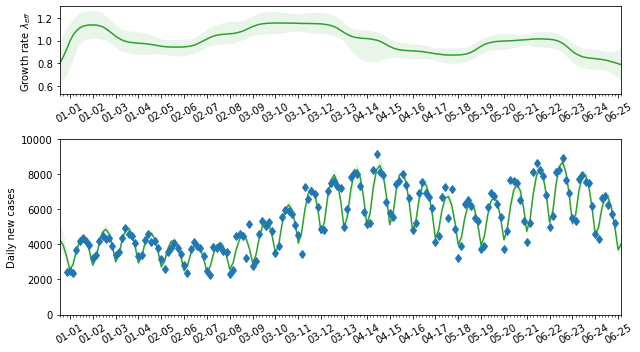

In [22]:


def plot_timeseries(trace, model, key, var=None, ax=None, **kwargs):
    # Get data
    if var is None:
        var = np.array(trace.posterior[key])
        var = var.reshape((var.shape[0]*var.shape[1],) + var.shape[2:])
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(16,8))

    axes = cov19.plot._timeseries(
        x=pd.date_range(this_model.sim_begin,this_model.sim_end),
        y=var[:,:],
        what="model",
        ax=ax,
        **kwargs
    )

    return axes

fig, axes = plt.subplots(2,1,figsize=(9,5), gridspec_kw={'height_ratios': [1, 2]})

# Plot new_cases
ax = plot_timeseries(trace,this_model,"new_cases",ax=axes[1])
cov19.plot._timeseries(new_cases_obs.index, new_cases_obs,what="data", ax=ax)
ax.set_ylim(0,10000)
ax.set_ylabel("Daily new cases")

# Plot lambda_t
ax = plot_timeseries(trace,this_model,"base_lambda_t",ax=axes[0])
ax.set_ylabel("Growth rate $\lambda_{eff}$")



for ax in axes:
    ax.set_xticklabels(ax.get_xticks(), rotation=30)
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(WeekdayLocator(interval=1))
    _ = ax.set_xlim(this_model.data_begin-timedelta(days=2), this_model.data_end+timedelta(days=2))
fig.tight_layout()

fig.savefig("./figures/lambda+cases.png",dpi=300)
fig.savefig("./figures/lambda+cases.pdf",dpi=300)

Text(0, 0.5, 'Growth rate $\\lambda_{eff}$')

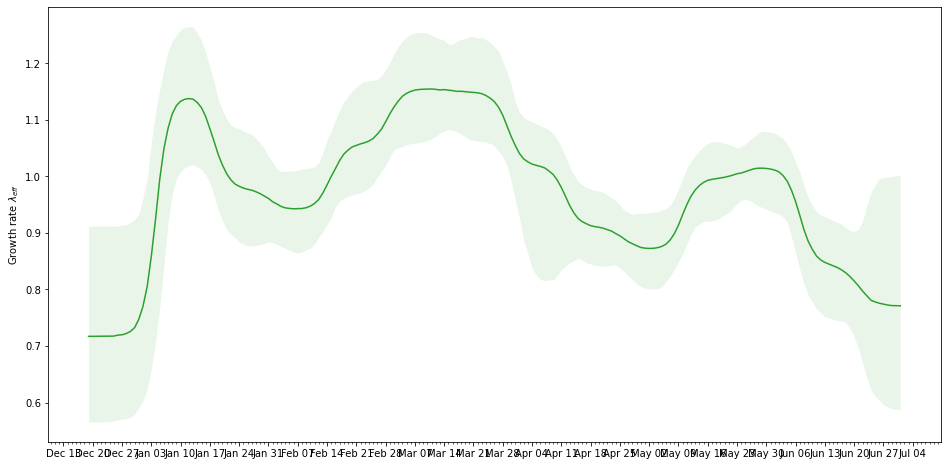

In [23]:
# Plot lambda_t
ax = plot_timeseries(trace,this_model,"base_lambda_t")
ax.set_ylabel("Growth rate $\lambda_{eff}$")

<ipython-input-24-6533150061fd>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=30)


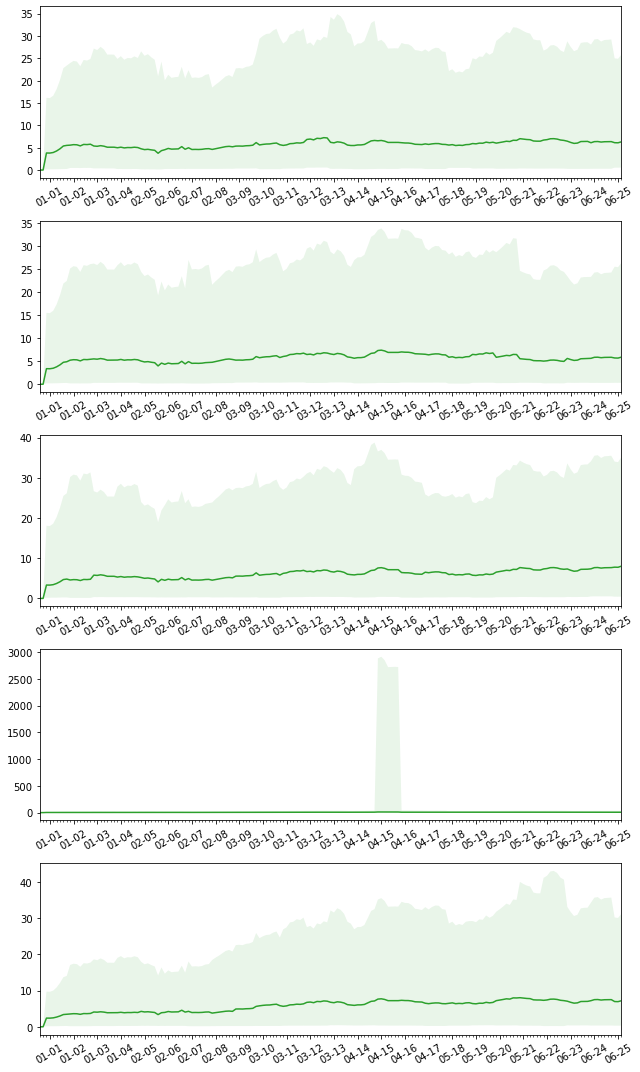

In [24]:
var = np.array(trace.posterior["Phi"])
var = var.reshape((var.shape[0]*var.shape[1],) + var.shape[2:])

fig, axes = plt.subplots(5,1,figsize=(9,3*5))
for v in range(len(variant_names)):
    plot_timeseries(trace,this_model,var=var[:,:,v], key="Phi",ax=axes[v])

for ax in axes:
    ax.set_xticklabels(ax.get_xticks(), rotation=30)
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(WeekdayLocator(interval=1))
    _ = ax.set_xlim(this_model.data_begin-timedelta(days=2), this_model.data_end+timedelta(days=2))
fig.tight_layout()

fig.savefig("./figures/influx.png",dpi=300)
fig.savefig("./figures/influx.pdf",dpi=300)

In [25]:
import datetime
def get_neighbour(be, en):
    jhu = covid19_inference.data_retrieval.JHU()
    jhu.download_all_available_data(force_local=True)
    cases = jhu.get_new(
        country="Argentina", data_begin=be - datetime.timedelta(days=7), data_end=en
    )
    cases += jhu.get_new(
        country="Brazil", data_begin=be - datetime.timedelta(days=7), data_end=en
    )
    cases += jhu.get_new(
        country="Peru", data_begin=be - datetime.timedelta(days=7), data_end=en
    )
    return np.array(cases.rolling(7).mean()[be:en])
get_neighbour(
                datetime.datetime(2021,4,1), datetime.datetime(2021, 4, 14)
            )

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


array([ 95152.71428571,  91961.57142857,  85481.57142857,  83949.71428571,
        83088.85714286,  84974.71428571,  85070.14285714,  86664.85714286,
        92570.57142857,  98711.14285714, 100209.14285714, 101736.85714286,
       102840.42857143, 100505.        ])

In [26]:
trace.posterior["Phi_w"].mean(['chain', 'draw', 'Phi_w_dim_1'])

<xarray.DataArray 'Phi_w' (Phi_w_dim_0: 6)>
array([9.56699559e-05, 9.56645357e-05, 1.01347234e-04, 3.02953182e-04,
       9.36571023e-05, 1.05014263e-04])
Coordinates:
  * Phi_w_dim_0  (Phi_w_dim_0) int64 0 1 2 3 4 5

<ipython-input-27-df74ec412f07>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=30)


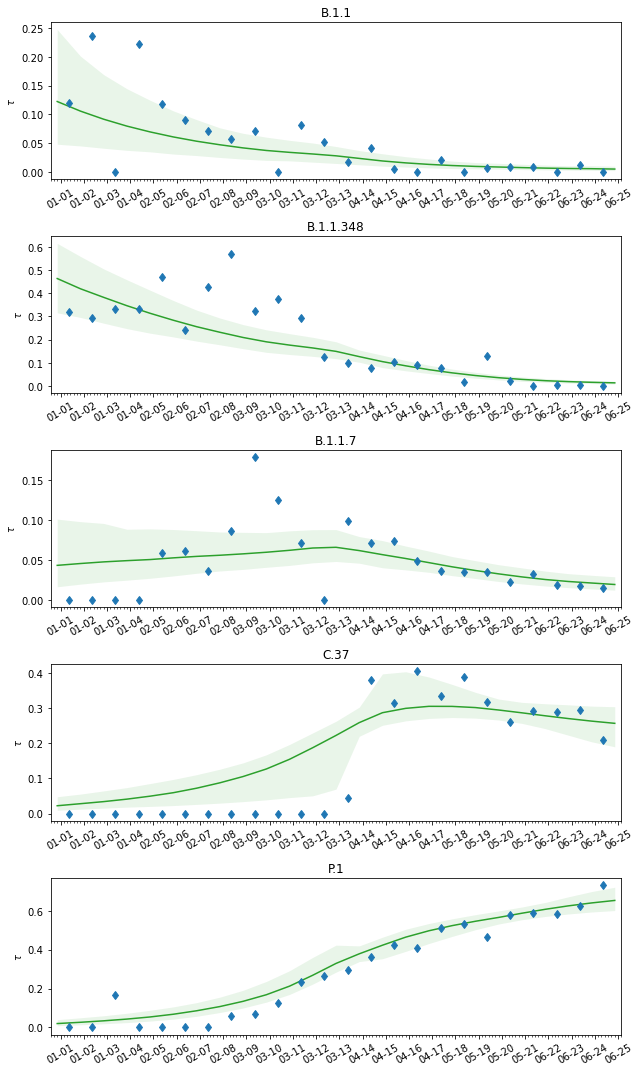

In [27]:
fig, axes = plt.subplots(len(variant_names),1,figsize=(9,3*5))
for v, variant in enumerate(variant_names):
    ax = cov19.plot._timeseries(
        x=variants.index,
        y=np.array(trace.posterior.tau_w).reshape((trace.posterior.tau_w.shape[0]*trace.posterior.tau_w.shape[1],trace.posterior.tau_w.shape[2],trace.posterior.tau_w.shape[-1],))[:,:,v],
        what="model",
        ax=axes[v]
    )
    ax = cov19.plot._timeseries(
            x=variants.index + timedelta(days=3.5),
            y=variants[variants.columns[v]]/variants["N_Total"],
            what="data",
        ax=ax
    )
    ax.set_title(variant)
    
for ax in axes:
    ax.set_xticklabels(ax.get_xticks(), rotation=30)
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(WeekdayLocator(interval=1))
    _ = ax.set_xlim(this_model.data_begin-timedelta(days=2), this_model.data_end+timedelta(days=2))
    
    # 
    ax.set_ylabel(r"$\tau$")
fig.tight_layout()
fig.savefig("./figures/tau.png",dpi=300)
fig.savefig("./figures/tau.pdf",dpi=300)

In [28]:
np.array(trace.posterior.tau).reshape((trace.posterior.tau.shape[0]*trace.posterior.tau.shape[1],trace.posterior.tau.shape[2],trace.posterior.tau.shape[-1],))[:,:,v].mean()

0.37734120125275633

/data.nst/jdehning/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(


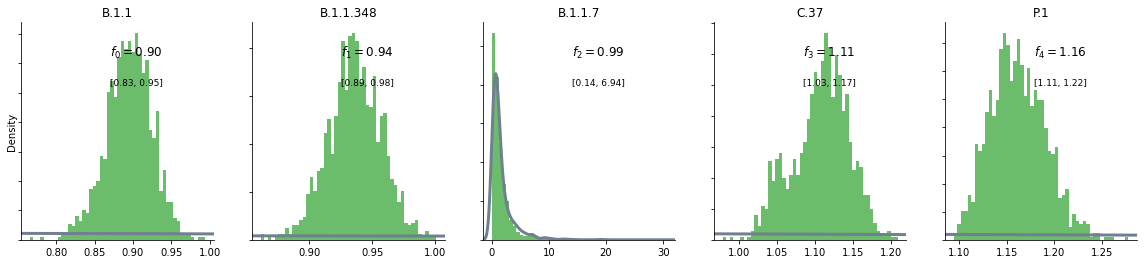

In [29]:
import plot as pl
from rcParams import *

axes = pl.distribution(this_model, trace, "f_v", title="", dist_math="f",)
fig = axes[0].get_figure()

for i, var in enumerate(variant_names):
    axes[i].set_title(var)
    
axes[0].set_ylabel("Density")

fig.savefig("./figures/f.png",dpi=300)
fig.savefig("./figures/f.pdf",dpi=300)

/data.nst/jdehning/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
WARNING  [plot] Could not calculate prior of f_tmp


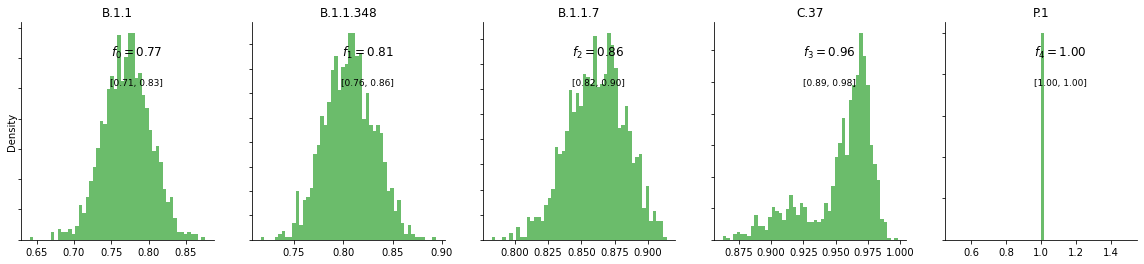

In [35]:
import plot as pl
from rcParams import *
relative_variant=4

trace.posterior['f_v'][...,2] = 1.
trace.posterior['f_tmp'] = trace.posterior['f_v']/trace.posterior['f_v'].isel(f_v_dim_0=relative_variant)

axes = pl.distribution(this_model, trace, "f_tmp", title="", dist_math="f",)
fig = axes[0].get_figure()

for i, var in enumerate(variant_names):
    axes[i].set_title(var)
    
axes[0].set_ylabel("Density")

fig.savefig("./figures/f.png",dpi=300)
fig.savefig("./figures/f.pdf",dpi=300)

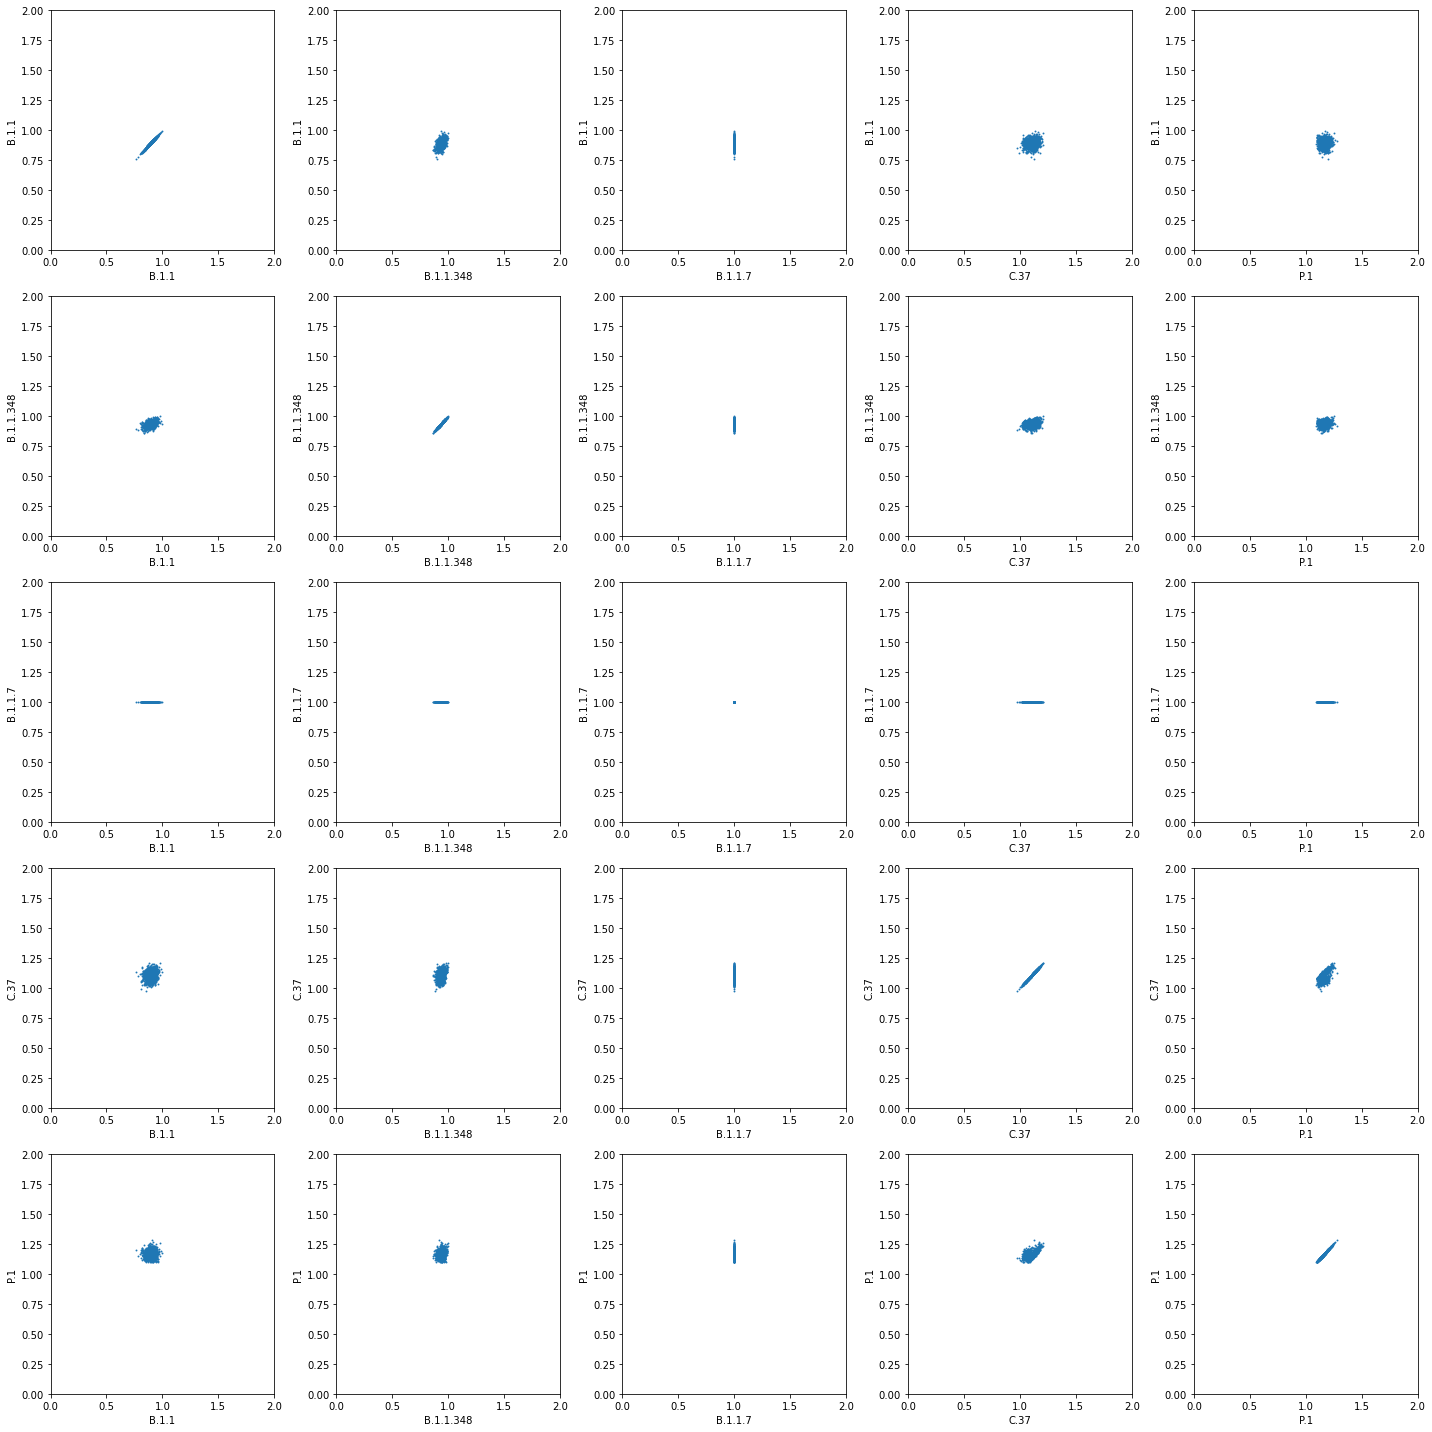

In [36]:
fig,axes = plt.subplots(len(variant_names),len(variant_names),figsize=(20,20))
for i in range(len(variant_names)):
    for j in range(len(variant_names)):
        x = np.array(trace.posterior.f_v[:,:,j]).flatten()
        y = np.array(trace.posterior.f_v[:,:,i]).flatten()
        axes[i,j].scatter(x,y, s=0.8)
        axes[i,j].set_xlim(0,2)
        axes[i,j].set_ylim(0,2)
        axes[i,j].set_xlabel(variant_names[j])
        axes[i,j].set_ylabel(variant_names[i])
fig.tight_layout()

/data.nst/jdehning/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(


[<AxesSubplot:>]

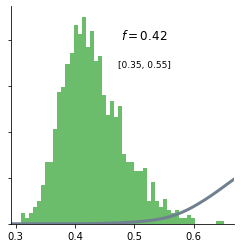

In [37]:
pl.distribution(this_model, trace, "factor_likelihood", title="", dist_math="f",)